Recurrent Neural Networks (RNNs) are widely used in real-life applications where **sequential data** is involved.


### Time Series Forecasting - Stock Price Prediction**
**Use Case:** Predict stock market trends based on past price data.  
**How RNN is used:**  
- Takes **historical stock prices** as input.
- LSTM-based RNNs identify patterns over **days, months, or years**.

Example:  
 Input: *Last 30 days of Apple stock prices*  
 Output: *Predicted price for tomorrow*



In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset

## Step 1: Load Stock Data
# Download Apple stock price data (Example CSV: 'AAPL.csv')
df = pd.read_csv('/content/sample_data/AAPL.csv')  # Ensure your CSV has a "Close" column
prices = df['Close'].values.reshape(-1, 1)  # Use only closing prices

# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
prices_scaled = scaler.fit_transform(prices)

In [3]:
## Step 2: Create Sequences (Sliding Window)
seq_length = 60  # Use last 60 days to predict next price
X, y = [], []

for i in range(len(prices_scaled) - seq_length):
    X.append(prices_scaled[i:i+seq_length])
    y.append(prices_scaled[i+seq_length])

X, y = np.array(X), np.array(y)

# Convert to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

# Create DataLoader
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [4]:
## Step 3: Define RNN (LSTM) Model
class StockPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(StockPredictor, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)  # Output is a single predicted price

    def forward(self, x):
        _, (hidden, _) = self.lstm(x)
        return self.fc(hidden[-1])  # Last hidden state → output

# Model parameters
input_size = 1  # Single feature (closing price)
hidden_size = 50  # Number of LSTM neurons
num_layers = 2  # Stacked LSTMs

model = StockPredictor(input_size, hidden_size, num_layers)

In [5]:
model

StockPredictor(
  (lstm): LSTM(1, 50, num_layers=2, batch_first=True)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)

In [6]:
## Step 4: Train Model
criterion = nn.MSELoss()  # Mean Squared Error loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 50
for epoch in range(epochs):
    for batch_X, batch_y in dataloader:
        optimizer.zero_grad()
        predictions = model(batch_X)
        loss = criterion(predictions, batch_y)
        loss.backward()
        optimizer.step()

    if epoch % 5 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item():.4f}')



Epoch 0, Loss: 0.1966
Epoch 5, Loss: 0.0609
Epoch 10, Loss: 0.0235
Epoch 15, Loss: 0.0149
Epoch 20, Loss: 0.0103
Epoch 25, Loss: 0.0064
Epoch 30, Loss: 0.0099
Epoch 35, Loss: 0.0100
Epoch 40, Loss: 0.0072
Epoch 45, Loss: 0.0059


In [7]:
def predict_future(model, last_days, scaler):
    model.eval() # Set the model to evaluation mode

    # 1. Reshape and scale `last_days`
    #    last_days (e.g., [100, 105, 110]) -> (sequence_length, 1) -> scaled_values (NumPy array)
    #    scaler.transform expects 2D input (n_samples, n_features)
    #    It will return a NumPy array of shape (sequence_length, 1)
    last_days_reshaped = last_days.reshape(-1, 1) # Ensure it's 2D for scaler
    last_days_scaled_np = scaler.transform(last_days_reshaped)

    # 2. Convert to PyTorch tensor and add batch dimension
    #    torch.from_numpy is efficient for NumPy arrays.
    #    .float() ensures it's float32.
    #    .unsqueeze(0) adds the batch_size dimension at the front,
    #    making the shape (1, sequence_length, 1) which is (batch_size, seq_len, input_features).
    input_seq = torch.from_numpy(last_days_scaled_np).float().unsqueeze(0)

    with torch.no_grad(): # Disable gradient calculation for inference
        # The model should output a tensor of shape (batch_size, output_features)
        # For a single prediction, this is likely (1, 1)
        predicted_scaled_price_tensor = model(input_seq)

        # .item() extracts the scalar value from the (1, 1) tensor
        predicted_scaled_price = predicted_scaled_price_tensor.item()

    # 3. Inverse transform the predicted scaled price back to original scale
    #    scaler.inverse_transform expects 2D input (n_samples, n_features).
    #    It will return a 2D NumPy array (e.g., [[original_price]]).
    #    [0][0] extracts the scalar from this 2D array.
    final_predicted_price = scaler.inverse_transform([[predicted_scaled_price]])[0][0]

    return final_predicted_price

In [8]:
# Get last 60 days of actual prices
last_60_days = prices[-seq_length:]

last_60_days

array([[135.720001],
       [136.660004],
       [139.779999],
       [139.139999],
       [139.990005],
       [140.639999],
       [143.660004],
       [143.339996],
       [141.050003],
       [142.270004],
       [143.649994],
       [148.960007],
       [156.100006],
       [153.059998],
       [153.610001],
       [155.449997],
       [148.979996],
       [142.270004],
       [146.279999],
       [144.020004],
       [144.179993],
       [149.039993],
       [150.270004],
       [149.5     ],
       [156.389999],
       [157.479996],
       [157.5     ],
       [159.860001],
       [164.050003],
       [158.630005],
       [159.880005],
       [151.889999],
       [154.119995],
       [155.300003],
       [156.990005],
       [156.25    ],
       [163.050003],
       [172.5     ],
       [174.669998],
       [170.149994],
       [174.970001],
       [171.050003],
       [169.369995],
       [173.970001],
       [175.009995],
       [169.229996],
       [175.      ],
       [177.0

In [9]:
# Predict next day's stock price
predicted_price = predict_future(model, last_60_days, scaler) # <--- ADDED 'scaler' here
print(f'Predicted Next Day Closing Price: ${predicted_price:.2f}')

Predicted Next Day Closing Price: $172.46


## Loads stock price data (from AAPL.csv with a "Close" column).

Normalizes the data for better learning.

Creates sequences of 60 past days → predicts next day's price.

Trains an LSTM model with 2 layers and 50 hidden neurons.

Predicts the next stock price using the last 60 days.

---------------------------------------------------------------------
🧠 Step-by-Step   Plan                                                               

Load and preprocess the Airline Passengers dataset

Normalize data

Create time steps for supervised learning

Split into training/testing sets

Build and train a second LSTM model

Similar architecture to your stock LSTM for fair comparison

Make predictions and visualize results

Plot Actual vs Predicted for both datasets

Label graphs clearly for comparison

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


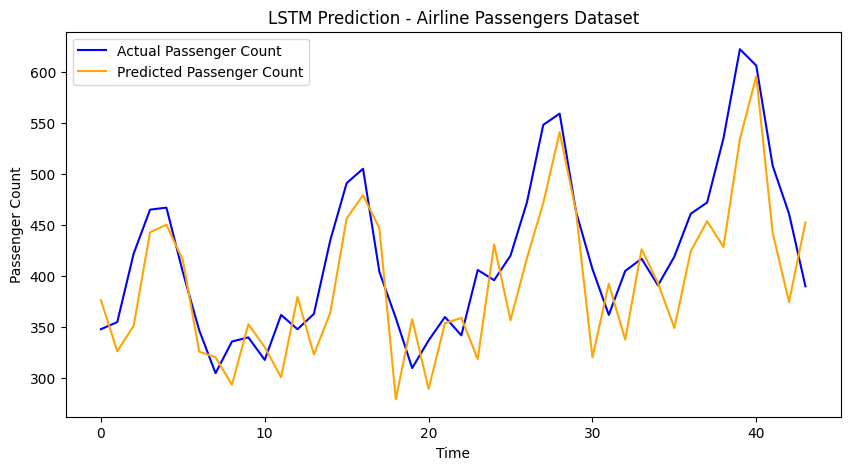

✅ LSTM model for Airline Passengers dataset completed.
Now compare this plot visually with your stock prediction plot above.


In [10]:
# -------------------------------
# LSTM on Airline Passengers Dataset
# -------------------------------

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

# Load Airline Passengers dataset
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
df2 = pd.read_csv(url, usecols=[1])
dataset2 = df2.values.astype('float32')

# Normalize dataset
scaler2 = MinMaxScaler(feature_range=(0, 1))
dataset2 = scaler2.fit_transform(dataset2)

# Split into train and test sets
train_size2 = int(len(dataset2) * 0.67)
test_size2 = len(dataset2) - train_size2
train2, test2 = dataset2[0:train_size2, :], dataset2[train_size2:len(dataset2), :]

# Convert to supervised learning
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

look_back = 3
trainX2, trainY2 = create_dataset(train2, look_back)
testX2, testY2 = create_dataset(test2, look_back)

# Reshape input to be [samples, time steps, features]
trainX2 = np.reshape(trainX2, (trainX2.shape[0], trainX2.shape[1], 1))
testX2 = np.reshape(testX2, (testX2.shape[0], testX2.shape[1], 1))

# Build LSTM model
model2 = Sequential()
model2.add(LSTM(50, input_shape=(look_back, 1)))
model2.add(Dense(1))
model2.compile(loss='mean_squared_error', optimizer='adam')

# Train model
model2.fit(trainX2, trainY2, epochs=100, batch_size=1, verbose=0)

# Predictions
trainPredict2 = model2.predict(trainX2)
testPredict2 = model2.predict(testX2)

# Invert predictions
trainPredict2 = scaler2.inverse_transform(trainPredict2)
trainY2 = scaler2.inverse_transform([trainY2])
testPredict2 = scaler2.inverse_transform(testPredict2)
testY2 = scaler2.inverse_transform([testY2])

# Plot Actual vs Predicted
plt.figure(figsize=(10,5))
plt.plot(testY2[0], label='Actual Passenger Count', color='blue')
plt.plot(testPredict2[:,0], label='Predicted Passenger Count', color='orange')
plt.title('LSTM Prediction - Airline Passengers Dataset')
plt.xlabel('Time')
plt.ylabel('Passenger Count')
plt.legend()
plt.show()

print("✅ LSTM model for Airline Passengers dataset completed.")
print("Now compare this plot visually with your stock prediction plot above.")
